In [2]:
!pip install boto3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import boto3
import io
from sklearn.linear_model import LinearRegression
import numpy as np

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.9/139.9 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.6/13.6 MB 84.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.2/85.2 kB 7.2 MB/s eta 0:00:00


In [4]:
s3 = boto3.client('s3',
                  aws_access_key_id=aws_access_key_id,
                  aws_secret_access_key=aws_secret_access_key,
                  aws_session_token=aws_session_token)


bucket = 'de300spring2025'
key = 'MOSES_group/midway_data/combined_midway_data.csv'

response = s3.get_object(Bucket=bucket, Key=key)

body = response['Body'].read().decode('utf-8')
df = pd.read_csv(io.StringIO(body))

df.head()

<ipython-input-4-4133647803>:13: DtypeWarning: Columns (7,8,9,10,11,13,15,16,17,18,19,20,21,23,27,33,35,36,37,38,39,40,41,42,43,44,45,47,48,49,50,51,52,60,61,62,63,65,66,71,77,90,91,92,93,94,95,96,97,98,99,100,101,104,105,106,107,108,109,110,111,112,113) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(io.StringIO(body))


,STATION,DATE,LATITUDE,LONGITUDE,ELEVATION,NAME,REPORT_TYPE,SOURCE,HourlyAltimeterSetting,HourlyDewPointTemperature,...,BackupDistance,BackupDistanceUnit,BackupElements,BackupElevation,BackupEquipment,BackupLatitude,BackupLongitude,BackupName,WindEquipmentChangeDate,source_file
0,72534014819,1973-01-01T00:00:00,41.78412,-87.75514,185.8,"CHICAGO MIDWAY AIRPORT, IL US",SY-SA,C,NaN,11.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2007-06-13,MOSES_group/midway_data/1973_72534014819.csv
1,72534014819,1973-01-01T01:00:00,41.78412,-87.75514,185.8,"CHICAGO MIDWAY AIRPORT, IL US",SAO,C,30.06,13.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2007-06-13,MOSES_group/midway_data/1973_72534014819.csv
2,72534014819,1973-01-01T02:00:00,41.78412,-87.75514,185.8,"CHICAGO MIDWAY AIRPORT, IL US",SAO,C,30.06,14.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2007-06-13,MOSES_group/midway_data/1973_72534014819.csv
3,72534014819,1973-01-01T03:00:00,41.78412,-87.75514,185.8,"CHICAGO MIDWAY AIRPORT, IL US",SAO,C,30.09,17.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2007-06-13,MOSES_group/midway_data/1973_72534014819.csv
4,72534014819,1973-01-01T04:00:00,41.78412,-87.75514,185.8,"CHICAGO MIDWAY AIRPORT, IL US",SAO,C,30.09,16.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2007-06-13,MOSES_group/midway_data/1973_72534014819.csv


In [5]:
pd.set_option('display.max_columns', None)
df = df.drop(columns=[col for col in df.columns if col.startswith('ShortDuration')])
df = df.drop(columns=[col for col in df.columns if col.startswith('Backup')])
df = df.drop(columns=[col for col in df.columns if col.startswith('Monthly')])

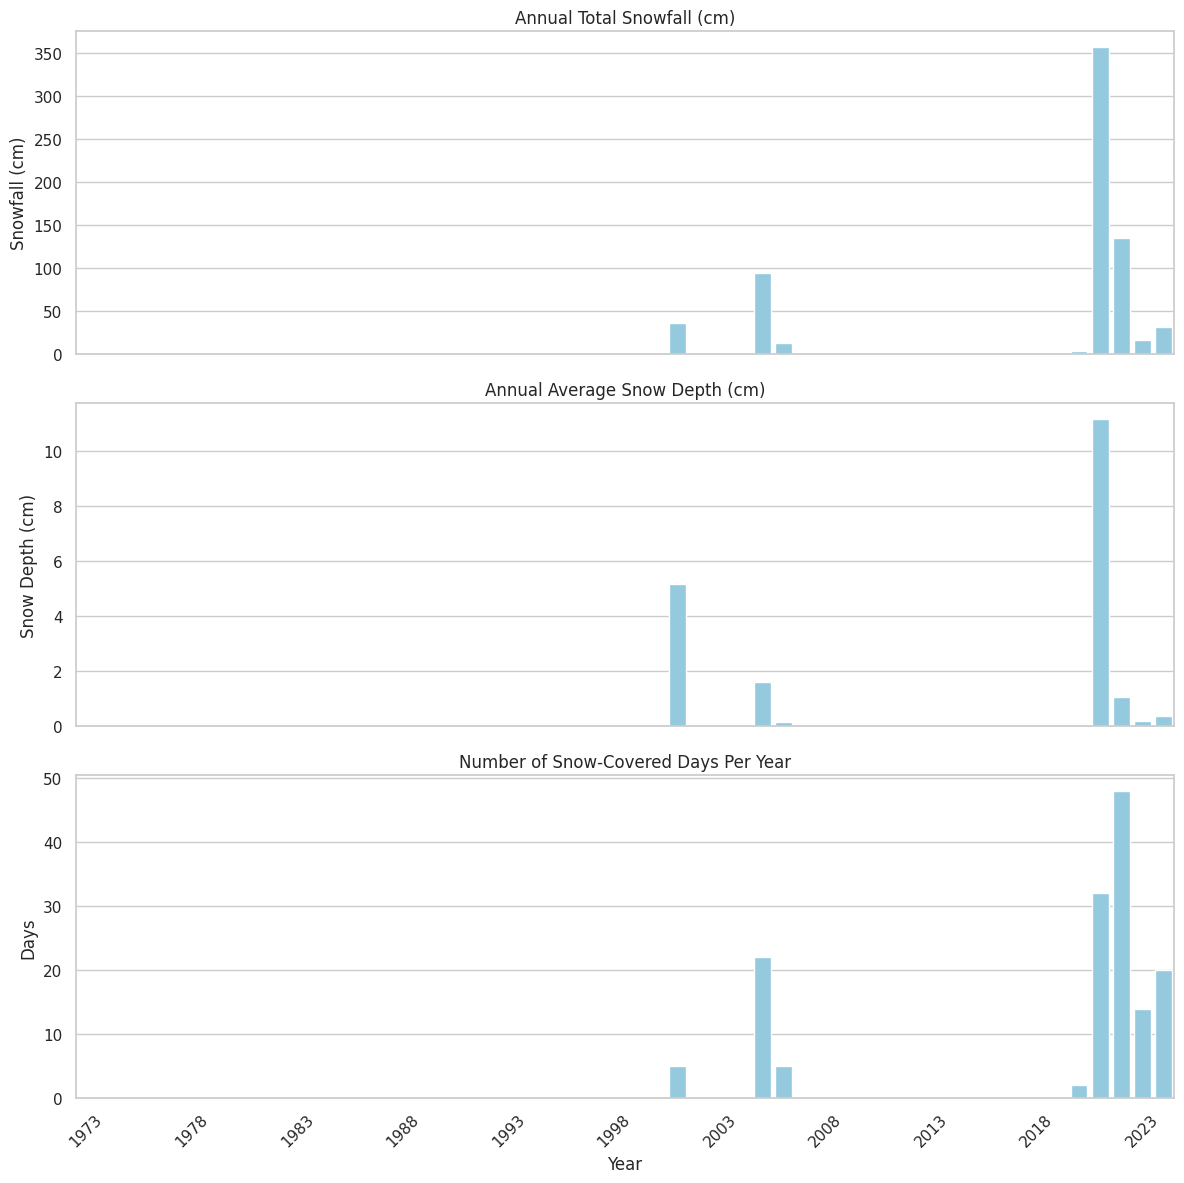

In [6]:
# Clean date column and extract year
df['DATE'] = pd.to_datetime(df['DATE'], errors='coerce')
df['year'] = df['DATE'].dt.year

# Clean data
def clean_snow_column(col):
    return pd.to_numeric(
        df[col].replace({'T': 0.0, 'M': pd.NA, '': pd.NA}), errors='coerce'
    )

df['DailySnowfall'] = clean_snow_column('DailySnowfall')
df['DailySnowDepth'] = clean_snow_column('DailySnowDepth')

# Group by year
snow_stats = df.groupby('year').agg(
    total_snowfall_cm=('DailySnowDepth', 'sum'),
    avg_snow_depth_cm=('DailySnowDepth', 'mean'),
    snow_covered_days=('DailySnowDepth', lambda x: (x > 0).sum())
).reset_index()

# Plot data
sns.set(style='whitegrid')
fig, axs = plt.subplots(3, 1, figsize=(12, 12), sharex=True)

sns.barplot(data=snow_stats, x='year', y='total_snowfall_cm', ax=axs[0], color='skyblue')
axs[0].set_title('Annual Total Snowfall (cm)')
axs[0].set_ylabel('Snowfall (cm)')

sns.barplot(data=snow_stats, x='year', y='avg_snow_depth_cm', ax=axs[1], color='skyblue')
axs[1].set_title('Annual Average Snow Depth (cm)')
axs[1].set_ylabel('Snow Depth (cm)')

sns.barplot(data=snow_stats, x='year', y='snow_covered_days', ax=axs[2], color='skyblue')
axs[2].set_title('Number of Snow-Covered Days Per Year')
axs[2].set_ylabel('Days')

plt.xlabel('Year')
axs[2].set_xticks(axs[2].get_xticks()[::5])
axs[2].tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()


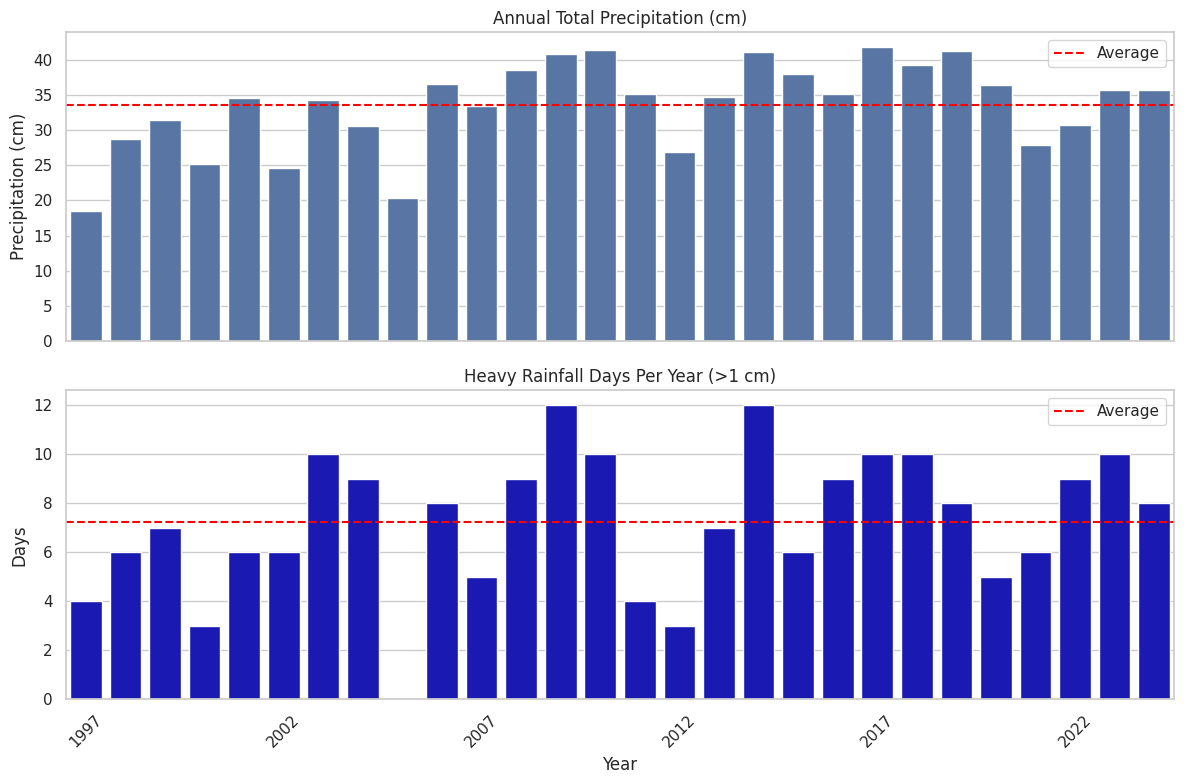

In [7]:
# Clean precipitation data
def clean_precip(col):
    return pd.to_numeric(
        df[col].replace({'T': 0.0, 'M': pd.NA, '': pd.NA}), errors='coerce'
    )

df['DailyPrecipitation'] = clean_precip('DailyPrecipitation')

# Group by year
precip_stats = df.groupby('year').agg(
    total_precip_cm=('DailyPrecipitation', 'sum'),
    heavy_rain_days=('DailyPrecipitation', lambda x: (x > 1).sum())   # Threshold: 1 cm
).reset_index()

# Filter to xlim range and convert to string for plotting
precip_stats = precip_stats[(precip_stats['year'] >= 1997) & (precip_stats['year'] <= 2024)]
precip_stats['year'] = precip_stats['year'].astype(str)

# Plot
sns.set(style='whitegrid')
fig, axs = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Total precipitation
sns.barplot(data=precip_stats, x='year', y='total_precip_cm', ax=axs[0])
axs[0].set_title('Annual Total Precipitation (cm)')
axs[0].set_ylabel('Precipitation (cm)')
axs[0].axhline(precip_stats['total_precip_cm'].mean(), color='red', linestyle='--', label='Average')
axs[0].legend()

# Heavy rainfall days
sns.barplot(data=precip_stats, x='year', y='heavy_rain_days', ax=axs[1], color='mediumblue')
axs[1].set_title('Heavy Rainfall Days Per Year (>1 cm)')
axs[1].set_ylabel('Days')
axs[1].axhline(precip_stats['heavy_rain_days'].mean(), color='red', linestyle='--', label='Average')
axs[1].legend()

# Shared x-axis formatting
plt.xlabel('Year')
axs[1].set_xticks(axs[1].get_xticks()[::5])
axs[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

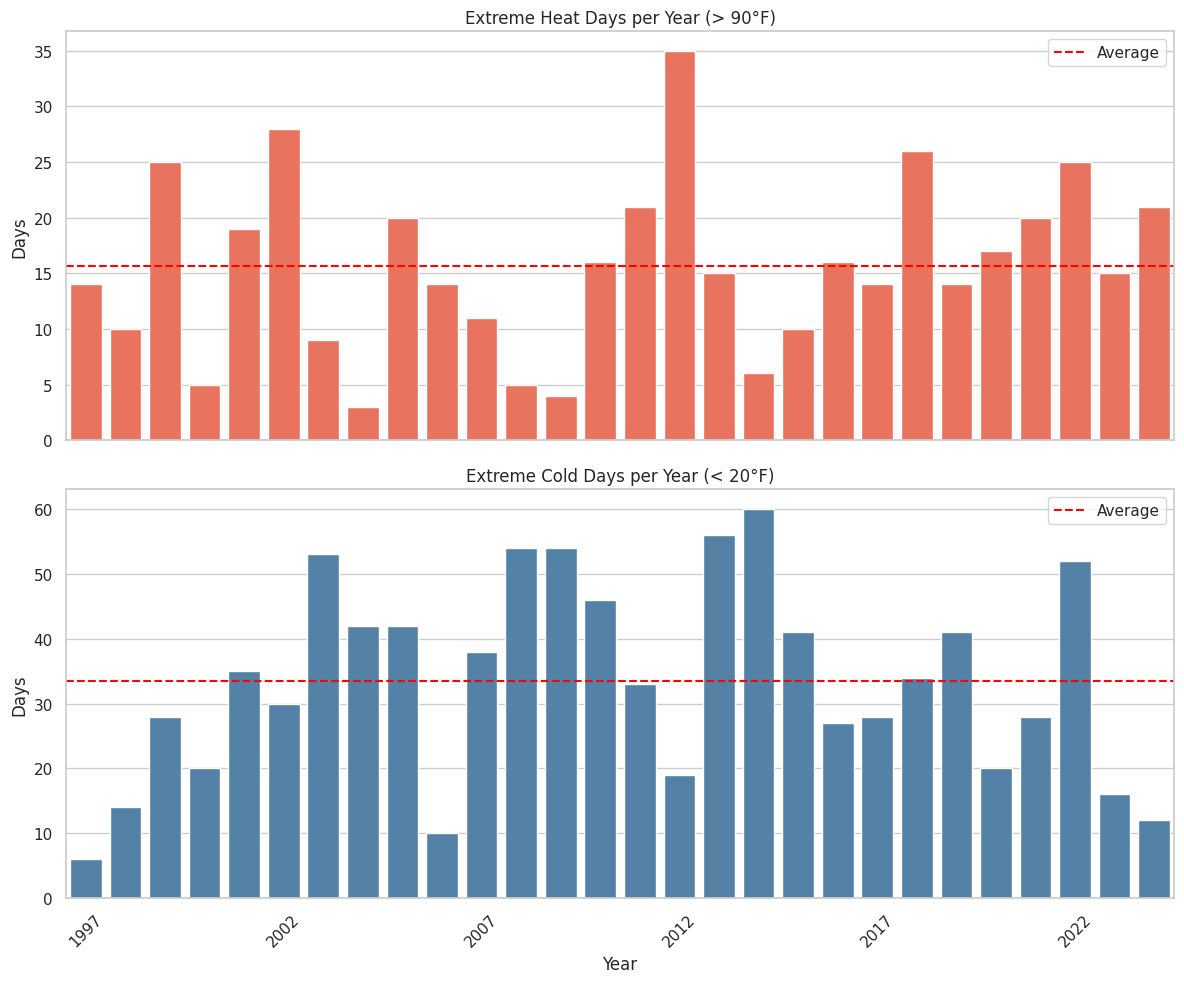

In [8]:
# Clean data
def clean_temp(col):
    return pd.to_numeric(df[col].replace({'M': pd.NA, '': pd.NA}), errors='coerce')

df['DailyAverageDryBulbTemperature'] = clean_temp('DailyAverageDryBulbTemperature')
df['DailyMaximumDryBulbTemperature'] = clean_temp('DailyMaximumDryBulbTemperature')
df['DailyMinimumDryBulbTemperature'] = clean_temp('DailyMinimumDryBulbTemperature')

# Define thresholds
extreme_heat_threshold_f = 90
extreme_cold_threshold_f = 20

# Group by year
temp_stats = df.groupby('year').agg(
    avg_temp_f=('DailyAverageDryBulbTemperature', 'mean'),
    max_temp_f=('DailyMaximumDryBulbTemperature', 'max'),
    min_temp_f=('DailyMinimumDryBulbTemperature', 'min'),
    extreme_heat_days=('DailyMaximumDryBulbTemperature', lambda x: (x > extreme_heat_threshold_f).sum()),
    extreme_cold_days=('DailyMinimumDryBulbTemperature', lambda x: (x < extreme_cold_threshold_f).sum())
).reset_index()

# Filter for 1997–2024 and convert year to string for plotting
temp_stats = temp_stats[(temp_stats['year'] >= 1997) & (temp_stats['year'] <= 2024)]
temp_stats['year'] = temp_stats['year'].astype(str)

# Calculate averages
avg_heat_days = temp_stats['extreme_heat_days'].mean()
avg_cold_days = temp_stats['extreme_cold_days'].mean()

# Plotting
sns.set(style='whitegrid')
fig, axs = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# Extreme heat
sns.barplot(data=temp_stats, x='year', y='extreme_heat_days', ax=axs[0], color='tomato')
axs[0].set_title(f'Extreme Heat Days per Year (> {extreme_heat_threshold_f}°F)')
axs[0].set_ylabel('Days')
axs[0].axhline(avg_heat_days, color='red', linestyle='--', label='Average')
axs[0].legend()

# Extreme cold
sns.barplot(data=temp_stats, x='year', y='extreme_cold_days', ax=axs[1], color='steelblue')
axs[1].set_title(f'Extreme Cold Days per Year (< {extreme_cold_threshold_f}°F)')
axs[1].set_ylabel('Days')
axs[1].axhline(avg_cold_days, color='red', linestyle='--', label='Average')
axs[1].legend()

# Shared x-axis formatting
plt.xlabel('Year')
axs[1].set_xticks(axs[1].get_xticks()[::5])
axs[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

Avg temperature trend: -0.018°F/year (-0.18°F/decade)


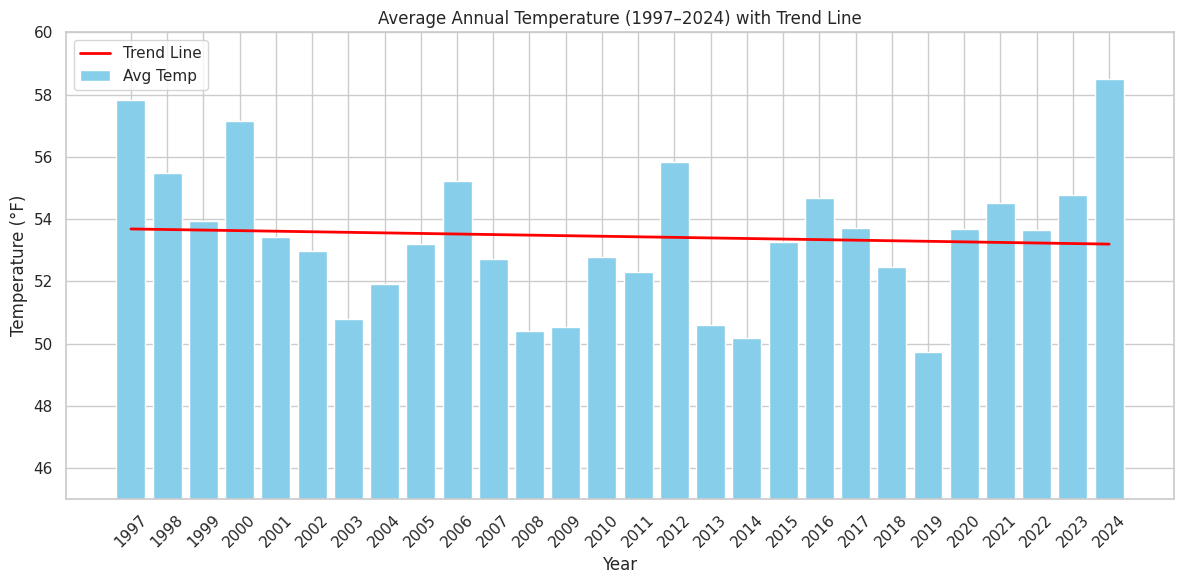

In [9]:
# Clean avg temp data
temp_clean = temp_stats.dropna(subset=['avg_temp_f']).copy()
temp_clean['year'] = temp_clean['year'].astype(int)

# Regression Analysis
X = temp_clean['year'].values.reshape(-1, 1)
y = temp_clean['avg_temp_f'].values
model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)

slope = model.coef_[0]
intercept = model.intercept_
print(f"Avg temperature trend: {slope:.3f}°F/year ({slope * 10:.2f}°F/decade)")

# Plot
plt.figure(figsize=(12, 6))
plt.bar(temp_clean['year'], temp_clean['avg_temp_f'], color='skyblue', label='Avg Temp')
plt.plot(temp_clean['year'], y_pred, color='red', linewidth=2, label='Trend Line')

plt.title('Average Annual Temperature (1997–2024) with Trend Line')
plt.ylabel('Temperature (°F)')
plt.xlabel('Year')
plt.xticks(temp_clean['year'], rotation=45)
plt.ylim(45, 60)
plt.legend()
plt.tight_layout()
plt.show()

<ipython-input-10-3230036743>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wind_direction_clean['wind_compass'] = pd.cut(
<ipython-input-10-3230036743>:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  prevailing = wind_direction_clean.groupby(['year', 'wind_compass']).size().reset_index(name='count')


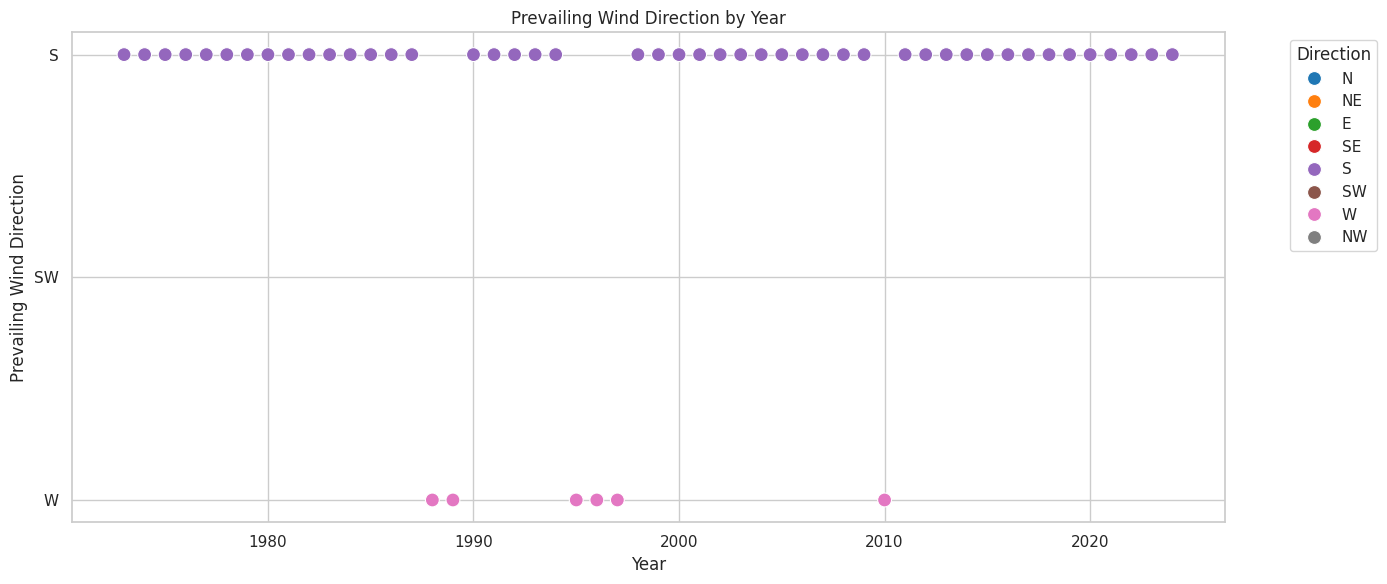

In [10]:
df['HourlyWindDirection'] = pd.to_numeric(df['HourlyWindDirection'], errors='coerce')
df['year'] = df['DATE'].dt.year

# Clean directional data
wind_direction_clean = df[df['HourlyWindDirection'] > 0]

# Bin directions into 8 categories
compass_bins = [0, 45, 90, 135, 180, 225, 270, 315, 360]
labels = ['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW']
wind_direction_clean['wind_compass'] = pd.cut(
    wind_direction_clean['HourlyWindDirection'],
    bins=compass_bins,
    labels=labels,
    include_lowest=True,
    right=False
)

prevailing = wind_direction_clean.groupby(['year', 'wind_compass']).size().reset_index(name='count')
prevailing = prevailing.sort_values(['year', 'count'], ascending=[True, False])
prevailing_wind = prevailing.groupby('year').first().reset_index()

# Plot
plt.figure(figsize=(14, 6))
sns.scatterplot(data=prevailing_wind, x='year', y='wind_compass', s=100, hue='wind_compass', palette='tab10')
plt.title('Prevailing Wind Direction by Year')
plt.xlabel('Year')
plt.ylabel('Prevailing Wind Direction')
plt.legend(title='Direction', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

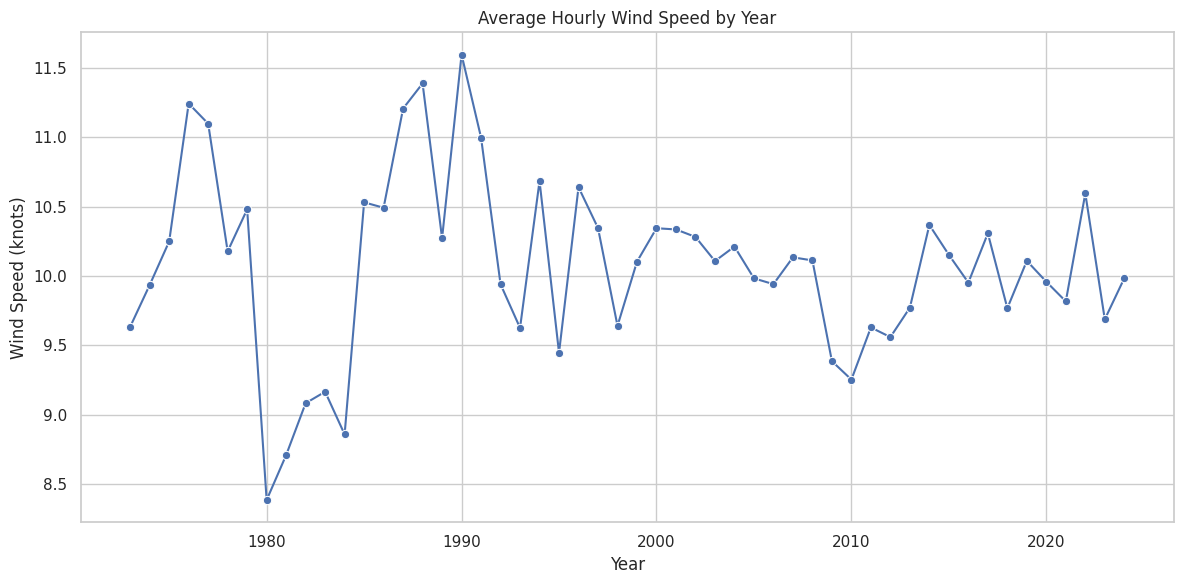

In [11]:
df['HourlyWindSpeed'] = pd.to_numeric(df['HourlyWindSpeed'], errors='coerce')

wind_speed_avg = df.groupby('year')['HourlyWindSpeed'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(data=wind_speed_avg, x='year', y='HourlyWindSpeed', marker='o')
plt.title('Average Hourly Wind Speed by Year')
plt.ylabel('Wind Speed (knots)')
plt.xlabel('Year')
plt.grid(True)
plt.tight_layout()
plt.show()

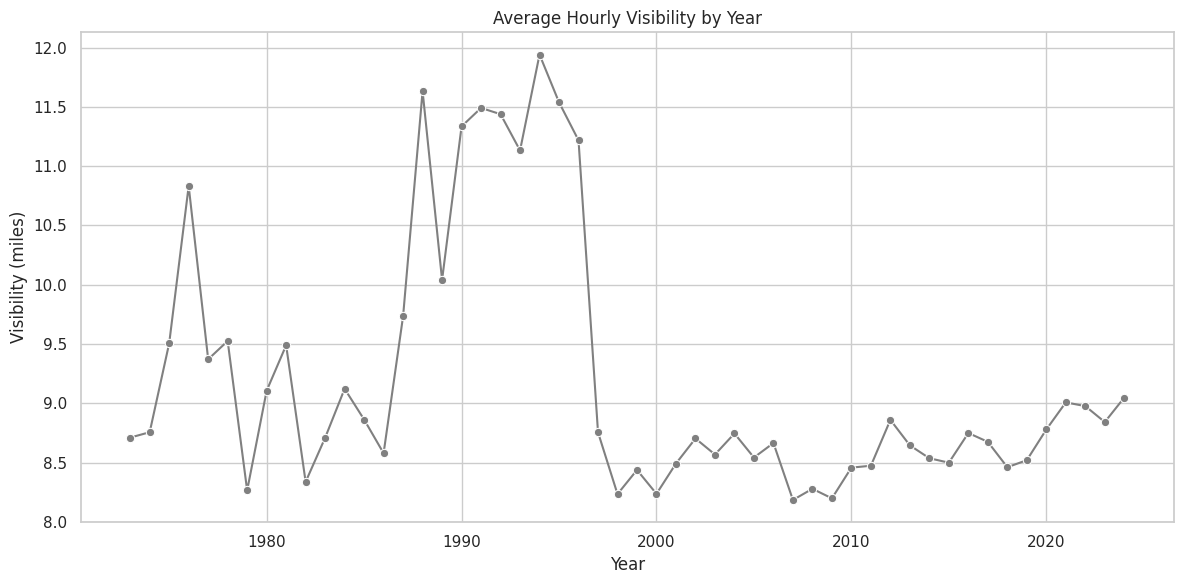

In [12]:
df['HourlyVisibility'] = pd.to_numeric(df['HourlyVisibility'], errors='coerce')

vis_trend = df.groupby('year')['HourlyVisibility'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(data=vis_trend, x='year', y='HourlyVisibility', marker='o', color='gray')
plt.title('Average Hourly Visibility by Year')
plt.ylabel('Visibility (miles)')
plt.xlabel('Year')
plt.grid(True)
plt.tight_layout()
plt.show()